# Run and Plot FluSight Forecasts (2024-2025 season)<a class="anchor" id="top"></a>

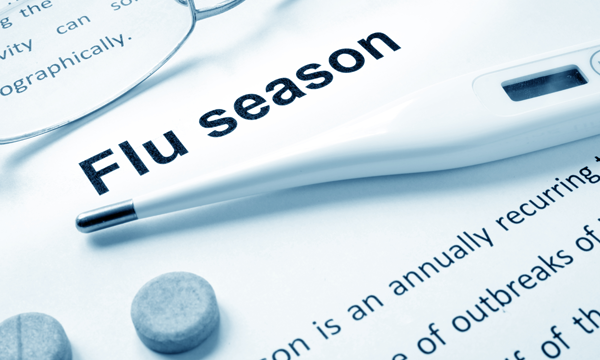

## Table of contents

* [Run forecast](#run-forecast)
* [Import forecast files](#import-forecast)
* [Plot fore quantiles](#plot-fore-quantiles)

In [1]:
import gc
import importlib
import os
from pathlib import Path
import sys
import time

import IPython.display
import ipywidgets as widgets
import matplotlib.pyplot as plt
import matplotlib as mpl
# from matplotlib import ticker
# from matplotlib import dates
from matplotlib.backends.backend_pdf import PdfPages
import numpy as np
import pandas as pd

# MANUALLY ADD RTREND LIBRARY PATH
sys.path.append("../../Rtrend_project/")
# Move to project root directory
if os.path.basename(os.getcwd()) != "programs":
    os.chdir("..")  # Move to project root
print(f"Working directory: {os.getcwd()}")

from rtrend_forecast.reporting import get_rtrend_logger, SUCCESS
import rtrend_forecast.visualization as vis
import utils.flusight_tools as fst
import utils.truth_data_structs as tds

# ------

_LOGGER = get_rtrend_logger().getChild("jupyter")
# ---
# %matplotlib notebook
%matplotlib widget
mpl.rcParams["pdf.fonttype"] = 42

main_rc = mpl.rcParams.copy()

main_rc["patch.linewidth"] = 0.
aggr_ref_tlabel = pd.Timestamp("2023-10-08")  # Sunday 00am, turns epiweek

# Define and reset the matplotlib figures in the notebook
try: 
    for _fig in mpl_figs: plt.close(_fig)
except NameError: pass
finally: mpl_figs = list()
plt.close("all")
gc.collect()
fig_kwargs = dict(num=1, clear=True) # Based on: https://stackoverflow.com/questions/28757348/how-to-clear-memory-completely-of-all-matplotlib-plots


Working directory: /Users/pventura/NonCloudStorage/Flu_forecast/programs


# Run forecast <a class="anchor" id="run-forecast"></a>

[Back to top](#top)

In [3]:
do_run = True
do_export = True
# now_str = pd.Timestamp.now().date().isoformat()
now_str = (pd.Timestamp.now() - pd.Timedelta("3d")).date().isoformat()
# now_str = "2024-04-22"  # Date of the last forecast done
print(f"Now str = {now_str}")

if do_run:
    xt0 = time.time()
    cmd = f"source activate rtrend_dev && python flusight_forecast.py --now {now_str}"
    cmd += "" if do_export else " --no-export"
    os.system(cmd)
    xtf = time.time()
    print("----------")
    print(f"Total script execution time = {xtf - xt0:0.2f}s")
else:
    print("Skipped")

Now str = 2025-01-26
[Alabama_2025-01-25] WARNING: 12 negative values were found in the preprocessed past incidence series  will be handled with method 'shift'. (`self.inc.past_gran_sr`). 
	 – The minimum is -0.06900399175060709.
	 – The sum is -0.5353194572724382.
[Idaho_2025-01-25] WARNING: 8 negative values were found in the preprocessed past incidence series  will be handled with method 'shift'. (`self.inc.past_gran_sr`). 
	 – The minimum is -0.0413825477208305.
	 – The sum is -0.2045845902937239.
[Arkansas_2025-01-25] Level 15: Forecast concluded
[Connecticut_2025-01-25] Level 15: Forecast concluded
[Alabama_2025-01-25] Level 15: Forecast concluded
[Florida_2025-01-25] Level 15: Forecast concluded
[Idaho_2025-01-25] Level 15: Forecast concluded
[Delaware_2025-01-25] WARNING: 34 negative values were found in the preprocessed past incidence series  will be handled with method 'shift'. (`self.inc.past_gran_sr`). 
	 – The minimum is -0.02993216842593227.
	 – The sum is -0.340424476691

[Texas_2025-01-25] Level 15: Forecast concluded
[New-York_2025-01-25] Level 15: Forecast concluded
[Utah_2025-01-25] WARNING: 15 negative values were found in the preprocessed past incidence series  will be handled with method 'shift'. (`self.inc.past_gran_sr`). 
	 – The minimum is -0.03528481133746593.
	 – The sum is -0.3566728948172817.
[Ohio_2025-01-25] Level 15: Forecast concluded
[Vermont_2025-01-25] WARNING: 28 negative values were found in the preprocessed past incidence series  will be handled with method 'shift'. (`self.inc.past_gran_sr`). 
	 – The minimum is -0.05430923611002514.
	 – The sum is -0.45161296644212323.
[Pennsylvania_2025-01-25] Level 15: Forecast concluded
[South-Dakota_2025-01-25] Level 15: Forecast concluded
[West-Virginia_2025-01-25] WARNING: There are 5 missing values in forecast region-of-interest. 
Dates: ['2024-09-07', '2024-09-14', '2024-09-21', '2024-09-28', '2024-10-05'].
Handled with method: fill with zeros.
[West-Virginia_2025-01-25] WARNING: 25 nega

# Import forecast files <a class="anchor" id="import-forecast"></a>

In [6]:
# -------------------------------
# PARAMETERS
# -------------------------------
truth_data_file = Path("hosp_data/truth_latest.csv")
# truth_data_file = Path("hosp_data/season_2024-2025/truth_2024-11-27.csv")
# now = pd.Timestamp(now_str)
now = pd.Timestamp.now()

# # --- Select output 
output_dir = Path("outputs/latest/")
flusight_output_file = Path("forecast_out/latest.csv")
now = pd.Timestamp(now_str)

# # # # # # # # # # # Past !! 
# output_dir = Path("outputs/flusight_2024-12-28/")
# flusight_output_file = Path("forecast_out/2024-12-28-CEPH-Rtrend_fluH.csv")
# # truth_data_file = Path("hosp_data/season_2024-2025/truth_2024-12-18.csv")

# # # Experimental
# output_dir = Path("outputs/tests/rtrend_refactor_after/")
# flusight_output_file = Path("forecast_out/tests/rtrend_refactor_after.csv")
# now = pd.Timestamp("2024-11-26")

# -------------------------------
# IMPORTS
# -------------------------------
importlib.reload(fst)
importlib.reload(tds)


obj = fst.FluSightGeneralOutputs(output_dir)
# truth = tds.FluDailyTruthData(truth_data_file)
truth = tds.FluWeeklyTruthData(truth_data_file, pop_data_path="aux_data/locations.csv")
dates = fst.FluSightDates(now)

fsobj = fst.FluSight2023Fore(flusight_output_file)

# TODO: The objects to hold the truth, forecast and hubverse forecast data should be revised!
#  They can have better patterns and be more compatible between one another.
    
obj.q_df

2025-01-26    2025-02-02    2025-02-09    2025-02-16  \
location_name quantile                                                          
Alabama       0.010       76.667139    514.525727    368.131147    255.116514   
              0.025       79.310833    534.026279    396.884629    287.832233   
              0.050       81.293604    553.853987    426.609669    321.539337   
              0.100       83.937299    577.316775    466.281608    364.466326   
              0.150       85.589608    594.500789    496.353633    398.817831   
...                             ...           ...           ...           ...   
US            0.850     5520.567631  40261.363481  42037.293913  40892.127940   
              0.900     5638.833329  41527.930004  44704.232878  44653.517881   
              0.950     5819.481139  43397.938281  48792.426377  50420.615949   
              0.975     5955.208536  44940.818809  52189.986317  55518.715704   
              0.990     6124.764594  46573.753877  55818.121212  60705.076850   

                          2025-02-23    2025-03-02    2025-03-09  
location_name quantile                                            
Alabama       0.010       174.150067    117.313941     69.066517  
              0.025       202.573087    140.115806     85.589608  
              0.050       234.627882    167.544136    103.765007  
              0.100       275.274684    204.555858    130.532413  
              0.150       311.955945    235.619268    153.334278  
...                              ...           ...           ...  
US            0.850     37154.706069  31779.737066  22530.466269  
              0.900     41349.345957  35798.728865  25530.318510  
              0.950     47981.566167  42214.214978  30246.327446  
              0.975     53703.039961  47600.678134  34228.429759  
              0.990     59599.781426  53250.684764  38232.031912  

[1196 rows x 7 columns]

# Quantile forecats <a class="anchor" id="plot-fore-quantiles"></a>

In [7]:
rc = main_rc.copy()
importlib.reload(vis)

do_save_plots = True
do_open_plots = True
# dt_behind = pd.Timedelta("3w")
dt_behind = pd.Timedelta("72w")
# dt_behind = pd.Timedelta("118w")

with plt.rc_context(rc):
    use_states = obj.q_df.index.get_level_values("location_name").unique()
    num_states = len(use_states)
    with plt.ioff():
        fig, axes = vis.make_axes_seq(num_states, max_cols=1, total_width=15., ax_height=6., fig_kwargs=fig_kwargs)  # Wider panels
        mpl_figs.append(fig)
    
    _LOGGER.info("Plotting...")
    for i_ax, state_name in enumerate(use_states):
        ax = axes[i_ax]
        
#         truth_sr = truth.xs_state_weekly(state_name, aggr_ref_tlabel).loc[dates.now - dt_behind:]
        truth_sr = truth.xs_state(state_name).loc[dates.now - dt_behind:]
        
        # -()- From forecast submission file
        plot_df = fsobj.quantiles_df.xs(truth.state_name_to_id[state_name], level="location").T
        
#         # -()- From general dataset
#         q_df = obj.q_df.xs(state_name).copy()
#         plot_df = q_df.iloc[:, 1:]  # EXCLUDES FIRST WEEK (incomplete)        
                
        # Plot commands
        # -------------
        # --- Truth series
#         ax.plot(truth_sr, "o-", ms=3)
        ax.plot(truth_sr)
    
        # --- Quantile forecats
        previous_week = plot_df.columns[0] - pd.Timedelta("1w")
        
        vis.plot_fore_quantiles_as_area(
            ax, plot_df,  
#             prepend_point=(previous_week, truth_sr[previous_week])
        )
        
        # --- Preprocessed (filtered) data
        if state_name != "US":
            filt_sr = obj.preproc_df.xs(state_name, level="location_name")["past_denoised"]
            ax.plot(filt_sr, "--")

        # Extra
        ax.set_title(f"{state_name} ({truth.state_name_to_id[state_name]})" )
        ax.text(  # R(t) synthesis method
            0.85, 0.85, obj.meta_dict["synth_method_used"].get(state_name, "[[no-method]]"),
            transform=ax.transAxes,
        )
        
        # NHSN data "disclaimer lines": report mandates
        ax.plot(2 * [pd.Timestamp("2024-05-01")], [0, truth_sr.max()], ":")
        ax.plot(2 * [pd.Timestamp("2024-11-01")], [0, truth_sr.max()], ":")
        
        ax.xaxis.set_major_locator(mpl.dates.AutoDateLocator())

        ax.set_xlim(dates.now - dt_behind, dates.now + pd.Timedelta("4w"))
        vis.rotate_ax_labels(ax)
    
    fig.tight_layout()
    
    if do_save_plots:
        os.makedirs("tmp_figs/", exist_ok=True)
        fig.savefig(f"tmp_figs/ct_states.pdf")
        print(f"Saved to tmp_figs dir. Click the link below to open:")
        flink = IPython.display.FileLink("../tmp_figs/ct_states.pdf")
        display(flink)
        if do_open_plots:
            os.system("open tmp_figs/ct_states.pdf")
        
    else:  # Only displays if not saved
        display(fig.canvas)



[jupyter] INFO: Plotting...
Saved to tmp_figs dir. Click the link below to open:


/Users/pventura/NonCloudStorage/Flu_forecast/tmp_figs/ct_states.pdf

# Reproduction number

[Back to run](#run-forecast)

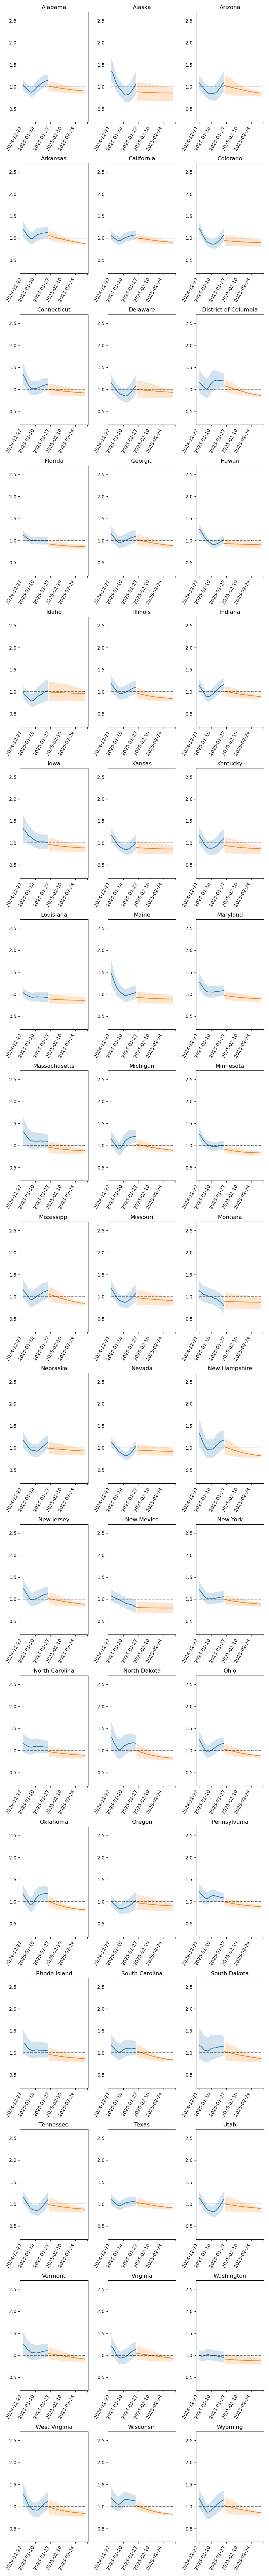

In [8]:

# ---------
rc = main_rc.copy()

do_save_plots = False

with plt.rc_context(rc):
    
#     # ----TEST
#     state_name = "California"
    use_states = obj.rt_past_df.index.get_level_values("location_name").unique()
    num_states = len(use_states)
    fig, axes = vis.make_axes_seq(num_states, total_width=8., ax_height=4.5)
    mpl_figs.append(fig)
    
    for i_ax, state_name in enumerate(use_states):
        ax = axes[i_ax]

        rt_past = obj.rt_past_df.xs(state_name, level="location_name").iloc[1:]
        rt_fore = obj.rt_fore_df.xs(state_name, level="location_name")

        # R(t) past
        ax.plot(rt_past["rt_past_median"])
        ax.fill_between(
            rt_past.index,
            rt_past["rt_past_low_q"],
            rt_past["rt_past_high_q"],
            alpha=0.2
        )

        # R(t) fore
        ax.plot(rt_fore["rt_fore_median"])
        ax.fill_between(
            rt_fore.index,
            rt_fore["rt_fore_low_q"],
            rt_fore["rt_fore_high_q"],
            alpha=0.2
        )
        # Reference lines
        ax.plot([rt_past.index[0], rt_fore.index[-1]], [1., 1.], "k--", alpha=0.5)

        # Extra
        ax.set_title(state_name)
        ax.set_ylim(0.2, 2.7)
        ax.xaxis.set_major_locator(mpl.dates.AutoDateLocator())
        vis.rotate_ax_labels(ax)
    
    fig.tight_layout()
    
    if do_save_plots:
        fig.savefig(f"tmp_figs/rt_states.pdf")
    

# Tests - View categorical rate change forecasts

[Back to run](#run-forecast)

In [9]:
# #-- -- - Load submittable file


fore_df = pd.read_csv(
    "forecast_out/latest.csv", 
#     "forecast_out/WEIRD_2024-12-21-CEPH-Rtrend_fluH.csv",
#     "forecast_out/2024-11-30-CEPH-Rtrend_fluH.csv",
    
    
#     "forecast_out/tests/old_forecast_test.csv", 
    parse_dates=["reference_date", "target_end_date"])

color_map = plt.get_cmap("RdYlGn")
color_i_seq = np.array([1.00, 0.75, 0.50, 0.25, 0.00])

target_end_date  2025-02-01  2025-02-08  2025-02-15  2025-02-22
output_type_id                                                 
large_decrease     0.146122    0.263163    0.372245    0.452551
decrease           0.000000    0.092449    0.117245    0.159388
stable             0.367347    0.214592    0.156122    0.125306
increase           0.000000    0.074388    0.085204    0.086327
large_increase     0.486531    0.355408    0.269184    0.176429

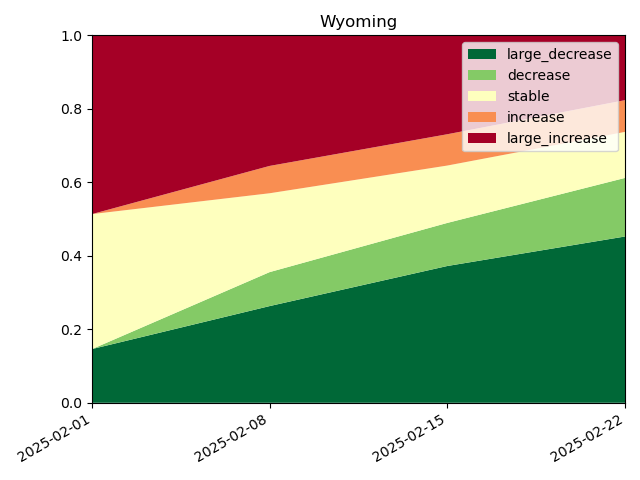

In [13]:
state_name = "Wyoming"  # "Illinois"  # "US"

# ----------
# -! NOTE will need to read the population file to convert between state ID and name

# -()- "Decrease" as base
rate_change_names = [
    "large_decrease", "decrease", "stable", "increase", "large_increase"]
color_i_seq = np.array([1.00, 0.75, 0.50, 0.25, 0.00])

# # -()- "Increase" as base (looks better, as moving to "increase" is actually an increasing curve)
# rate_change_names = [
#     "large_increase", "increase", "stable", "decrease", "large_decrease"]
# color_i_seq = np.array([0.0, 0.25, 0.50, 0.75, 1.0])


rate_change_id = {name: i for i, name in enumerate(rate_change_names)}  # Signature: r[i] = name

# ---------------

# -! TODO: also a version that aggregates some levels.

# --- Select data (state, rate change)
df = fore_df.loc[
      (fore_df["location"] == truth.state_name_to_id[state_name])
    & (fore_df["target"] == "wk flu hosp rate change")
    & (fore_df["output_type"] == "pmf")
]

# --- Convert values into a 2D table 
df.set_index(["output_type_id", "target_end_date"], inplace=True)
df.reindex()

value_table = df["value"].unstack("target_end_date").loc[rate_change_names]
#  ^  ^  Signature: df.loc[output_type_id, target_end_date]

display(value_table)

# --------------- PLOT

rc = dict()
rc["axes.prop_cycle"] = mpl.cycler(color=color_map(color_i_seq))

with mpl.rc_context(rc):
    fig, ax = plt.subplots()

    ax.stackplot(value_table.columns, value_table, labels=rate_change_names)
    
    # TODO: set locator
    ax.legend()
    ax.set_title(state_name)
    ax.set_xlim(value_table.columns[0], value_table.columns[-1])
    ax.set_ylim(0., 1.0)
    
    ax.xaxis.set_major_locator(mpl.dates.WeekdayLocator(5))
    
    vis.rotate_ax_labels(ax, angle=30)
    fig.tight_layout()

In [92]:
# value_table.sort_index(axis=0, key=lambda s: rate_change_id[s])
value_table.loc[rate_change_names]

target_end_date  2024-12-21  2024-12-28  2025-01-04  2025-01-11
output_type_id                                                 
large_decrease     0.000000    0.000000    0.000000    0.000000
decrease           0.000000    0.000000    0.000000    0.000000
stable             0.000000    0.000000    0.000000    0.030204
increase           0.927959    0.795612    0.875306    0.969694
large_increase     0.072041    0.204388    0.124694    0.000102

----